# Synthetic and Qrel System Ordering Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import csv
import glob
import os

## Experiment Config

In [2]:
# Parameters configuration
task = 'fullrank'
metric = 'ndcg_cut_10'
cut_off = '10'

# File path
metadata_file = 'metadata'

nist_qrel_file = 'qrels/2023.qrels.pass.withDupes.txt'

nist_ndcgeval_file = 'results/TRECDL2023/all.pass.nist.ndcgeval'
gpt4_ndcgeval_file = 'results/TRECDL2023/all.pass.gpt4.ndcgeval'

## Loading metadata
Loading the metadata file to create a dictionary of runid to subtask, loading the metadata_models file to have the pipeline structure, adding the subtask info to metadata models dataframe

In [3]:
runid_to_subtasks = dict()
with open(metadata_file, 'rt', encoding = 'utf8') as f:
    reader = csv.reader(f, delimiter = ':')
    for [runid, group, _, _, _, _, maintask, _, subtask, _, _, _, _, model, _, _, _, _] in reader:
        runid_to_subtasks[runid] = subtask.split('-')[0]

In [4]:
# loading metadeta infomrmaiton for runs, we have the type of pipeline as a metadata here
metadata_models_df = pd.read_csv('metadata_models.csv', sep="\t")
metadata_models_df.head()

,run_id,LLM,pipeline
0,colbertv2,-,Colbert-v2 and using pre-trained checkpoint an...
1,cip_run_7,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
2,cip_run_1,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
3,cip_run_2,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...
4,cip_run_3,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...


In [5]:
metadata_models_df['subtask'] = metadata_models_df['run_id'].map(runid_to_subtasks)
metadata_models_df.head(60)

,run_id,LLM,pipeline,subtask
0,colbertv2,-,Colbert-v2 and using pre-trained checkpoint an...,fullrank
1,cip_run_7,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
2,cip_run_1,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
3,cip_run_2,MonoT5/GPT-3.5/GPT-4,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
4,cip_run_3,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
5,cip_run_4,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
6,cip_run_5,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
7,cip_run_6,MonoT5/GPT-3.5,Unicoil+doct5query (pyserini)%0A2. MonoT5-3b (...,fullrank
8,agg-cocondenser,-,Aggretriever is a dense retriever with semanti...,fullrank
9,slim-pp-0shot-uw,-,SPRINT-https%3A//arxiv.org/pdf/2302.06587.pdf-...,fullrank


## Loading System Performance based on NIST Qrel

In [6]:
nist_qrels = pd.read_csv(nist_qrel_file, sep=' ', header=None, names=['qid', 'Q0', 'docid', 'rel'])

queries_judged = set(nist_qrels['qid'])

real_queries_judged = [x for x in queries_judged if x < 3000000]
t5_queries_judged = [x for x in queries_judged if x > 3000000 and x < 3100000]
gpt4_queries_judged = [x for x in queries_judged if x > 3100000]

print('queries_judged', len(queries_judged))
print('real_queries_judged', len(real_queries_judged))
print('t5_queries_judged', len(t5_queries_judged))
print('gpt4_queries_judged', len(gpt4_queries_judged))

queries_judged 82
real_queries_judged 51
t5_queries_judged 13
gpt4_queries_judged 18


### Loading runs ndcgecal on NIST qrels 

In [7]:
nist_labels_ndcgeval = pd.read_csv(nist_ndcgeval_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
# nist_labels_ndcgeval['runid_metric'] = nist_labels_ndcgeval['runid_metric'].str.strip()
# nist_labels_ndcgeval[['run_id', 'metric']] = nist_labels_ndcgeval['runid_metric'].str.split(' ', expand=True)
# nist_labels_ndcgeval = nist_labels_ndcgeval.drop('runid_metric', axis=1)
nist_labels_ndcgeval.head()

,run_id,metric,qid,score
0,cip_run_7,Rndcg,2001010,0.6321
1,cip_run_7,ndcg_cut_5,2001010,1.0000
2,cip_run_7,ndcg_cut_10,2001010,0.8563
3,cip_run_7,ndcg_cut_15,2001010,0.8769
4,cip_run_7,ndcg_cut_20,2001010,0.9080


In [8]:
# removing the runs that are for reranking task (4 runs for reranking) -> 39 runs will be remain
included_runids = metadata_models_df[metadata_models_df['subtask'] == task]['run_id']
print(len(set(included_runids)))

# We have {'D_bm25_splades', 'D_naverloo-frgpt4', 'D_naverloo_bm25_RR', 'D_naverloo_bm_splade_RR', 'colbertv2'}
# runs that have not submitted their results. So, we have 40 run_ids in metadata file in total, the rerank ones (4 runs) 
# are rmeoved from the list using the above command. Then, 36 runs we have, in whiche 5 submissions are have not submitteed their reuslt
# so we will have 31 submissions in total.

# nist_labels_ndcgeval = nist_labels_ndcgeval[nist_labels_ndcgeval['run_id'].isin(included_runids)]
print(len(set(nist_labels_ndcgeval['run_id'])))

36
35


In [10]:
nist_labels_ndcgeval = nist_labels_ndcgeval[nist_labels_ndcgeval['qid'] != 'all']
nist_labels_ndcgeval['qid'] = nist_labels_ndcgeval['qid'].astype(int)
nist_labels_ndcgeval['score']

0        0.6321
1        1.0000
2        0.8563
3        0.8769
4        0.9080
          ...  
29035    0.7748
29036    0.7956
29037    0.7956
29038    0.7956
29039    0.7956
Name: score, Length: 28700, dtype: float64

In [11]:
print(len(set(nist_labels_ndcgeval['run_id'])))

35


In [12]:
nist_labels_ndcgeval = nist_labels_ndcgeval[nist_labels_ndcgeval['qid'] != 'all']
nist_labels_ndcgeval['qid'] = nist_labels_ndcgeval['qid'].astype(int)

track_queries_nist_labels = nist_labels_ndcgeval[(nist_labels_ndcgeval['metric'] == metric) & (nist_labels_ndcgeval['qid'].isin(queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
track_queries_nist_labels = track_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_track_nist = dict(zip(track_queries_nist_labels['run_id'], track_queries_nist_labels[metric]))

generated_queries_nist_labels = nist_labels_ndcgeval[(nist_labels_ndcgeval['metric'] == metric) & ((nist_labels_ndcgeval['qid'].isin(t5_queries_judged)) | ((nist_labels_ndcgeval['qid'].isin(gpt4_queries_judged)))) ].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
generated_queries_nist_labels = generated_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_generated_nist = dict(zip(generated_queries_nist_labels['run_id'], generated_queries_nist_labels[metric]))

real_queries_nist_labels = nist_labels_ndcgeval[(nist_labels_ndcgeval['metric'] == metric) & (nist_labels_ndcgeval['qid'].isin(real_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
real_queries_nist_labels = real_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_real_nist = dict(zip(real_queries_nist_labels['run_id'], real_queries_nist_labels[metric]))

t5_queries_nist_labels = nist_labels_ndcgeval[(nist_labels_ndcgeval['metric'] == metric) & (nist_labels_ndcgeval['qid'].isin(t5_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
t5_queries_nist_labels = t5_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_t5_nist = dict(zip(t5_queries_nist_labels['run_id'], t5_queries_nist_labels[metric]))

gpt4_queries_nist_labels = nist_labels_ndcgeval[(nist_labels_ndcgeval['metric'] == metric) & (nist_labels_ndcgeval['qid'].isin(gpt4_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
gpt4_queries_nist_labels = gpt4_queries_nist_labels.rename(columns={'mean':metric})
runid_to_score_gpt4_nist = dict(zip(gpt4_queries_nist_labels['run_id'], gpt4_queries_nist_labels[metric]))

### Loading runs ndcgecal on Synthetic (GPT-4 -- V3) qrels 

In [13]:
gpt4_labels_ndcgeval = pd.read_csv(gpt4_ndcgeval_file, sep='\t', header=None, names=['run_id', 'metric', 'qid', 'score'])
gpt4_labels_ndcgeval.head()

,run_id,metric,qid,score
0,naverloo_fs_RR_duo,Rndcg,2001010,0.7327
1,naverloo_fs_RR_duo,ndcg_cut_5,2001010,0.9435
2,naverloo_fs_RR_duo,ndcg_cut_10,2001010,0.8439
3,naverloo_fs_RR_duo,ndcg_cut_15,2001010,0.9007
4,naverloo_fs_RR_duo,ndcg_cut_20,2001010,0.8875


In [14]:
# gpt4_labels_ndcgeval = gpt4_labels_ndcgeval[gpt4_labels_ndcgeval['run_id'].isin(included_runids)]
len(set(gpt4_labels_ndcgeval['run_id']))

35

In [15]:
gpt4_labels_ndcgeval = gpt4_labels_ndcgeval[gpt4_labels_ndcgeval['qid'] != 'all']
gpt4_labels_ndcgeval['qid'] = gpt4_labels_ndcgeval['qid'].astype(int)

track_queries_gpt4_labels = gpt4_labels_ndcgeval[(gpt4_labels_ndcgeval['metric'] == metric) & (gpt4_labels_ndcgeval['qid'].isin(queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
track_queries_gpt4_labels = track_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_track_gpt4 = dict(zip(track_queries_gpt4_labels['run_id'], track_queries_gpt4_labels[metric]))

real_queries_gpt4_labels = gpt4_labels_ndcgeval[(gpt4_labels_ndcgeval['metric'] == metric) & (gpt4_labels_ndcgeval['qid'].isin(real_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
real_queries_gpt4_labels = real_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_real_gpt4 = dict(zip(real_queries_gpt4_labels['run_id'], real_queries_gpt4_labels[metric]))

generated_queries_gpt4_labels = gpt4_labels_ndcgeval[(gpt4_labels_ndcgeval['metric'] == metric) & ((gpt4_labels_ndcgeval['qid'].isin(t5_queries_judged)) | ((gpt4_labels_ndcgeval['qid'].isin(gpt4_queries_judged)))) ].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
generated_queries_gpt4_labels = generated_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_generated_gpt4 = dict(zip(generated_queries_gpt4_labels['run_id'], generated_queries_gpt4_labels[metric]))

t5_queries_gpt4_labels = gpt4_labels_ndcgeval[(gpt4_labels_ndcgeval['metric'] == metric) & (gpt4_labels_ndcgeval['qid'].isin(t5_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
t5_queries_gpt4_labels = t5_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_t5_gpt4 = dict(zip(t5_queries_gpt4_labels['run_id'], t5_queries_gpt4_labels[metric]))

gpt4_queries_gpt4_labels = gpt4_labels_ndcgeval[(gpt4_labels_ndcgeval['metric'] == metric) & (gpt4_labels_ndcgeval['qid'].isin(gpt4_queries_judged))].groupby('run_id')['score'].agg(['mean', 'count']).reset_index()
gpt4_queries_gpt4_labels = gpt4_queries_gpt4_labels.rename(columns={'mean':metric})
runid_to_score_gpt4_gpt4 = dict(zip(gpt4_queries_gpt4_labels['run_id'], gpt4_queries_gpt4_labels[metric]))

### Loading Configs

In [17]:
# loading the metadata and assigning LLM tag based on the pipeline of each run
run_to_model = {}
# red: gpt, yellow: t5, orange: gpt+t5, and blue: everything else
for eachline in metadata_models_df.itertuples(index=True):
    # if we have both T5 and GPT version in the pipeline
    if 'T5' in eachline.LLM and 'GPT' in eachline.LLM:
        run_to_model[eachline.run_id] = 'GPT+T5'
    elif 'GPT' in eachline.LLM:
        run_to_model[eachline.run_id] = 'GPT'
    elif 'T5' in eachline.LLM:
        run_to_model[eachline.run_id] = 'T5'
    else:
        run_to_model[eachline.run_id] = 'Others'

In [18]:
def get_merged_df(dict_1, dict_2):

    # Convert dictionaries to DataFrames
    df1 = pd.DataFrame(list(dict_1.items()), columns=['Key', 'Value1'])
    df2 = pd.DataFrame(list(dict_2.items()), columns=['Key', 'Value2'])

    # Merge the DataFrames based on the 'Key' column
    merged_df = pd.merge(df1, df2, on='Key', how='outer')

    return merged_df

In [19]:
model_to_color = {'GPT': 'red', 'T5': 'brown', 'GPT+T5': 'orange', 'Others': 'green'}
model_to_marker = {'GPT': 'x', 'T5': '|', 'GPT+T5': '+', 'Others': '.'}

## 3. Generating Plots for Various Types of Analysis

In [20]:
def get_plot(x_avg_scores, y_avg_scores, query_types=['track', 'real'], label_types=['NIST', 'NIST']):

    import seaborn as sns

    sns.set_style("ticks")  # Options: white, dark, whitegrid, darkgrid, ticks
    sns.set_context("poster", font_scale =0.6)     # Options: paper, notebook, talk, poster
    sns.set_palette("bright")   # You can also use: deep, muted, bright, dark, colorblind, or a custom list of colors

    # splitting query types
    query_type_x = query_types[0]
    query_type_y = query_types[1]

    # splitting query types
    label_type_x = label_types[0]
    label_type_y = label_types[1]

    if label_type_x == 'Sparse':
        metric_type_x = f"NDCG@{cut_off}"
    else:
        metric_type_x = f"NDCG@{cut_off}"

    if label_type_y == 'Sparse':
        metric_type_y = f"NDCG@{cut_off}"
    else:
        metric_type_y = f"NDCG@{cut_off}"

    merged_df = get_merged_df(x_avg_scores, y_avg_scores)

    for eachline in merged_df.itertuples(index=True):
        run_model = run_to_model[eachline.Key]
        model_color = model_to_color[run_model]
        model_marker = model_to_marker[run_model]
        plt.scatter(eachline.Value1, eachline.Value2, c=f"{model_color}", marker=f"{model_marker}", label=f"{run_model}", s=90)

    if label_type_x != 'Sparse' and label_type_y != 'Sparse':
        # axes
        ax = plt.gca()
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
            np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
            ]
        
        # now plot both limits against eachother
        ax.plot(lims, lims, color='blue', linestyle='dashed', linewidth=0.7)
    
    tau, p_value = stats.kendalltau(merged_df['Value1'], merged_df['Value2'])

    #adding tau inside the plot 
    plt.annotate(r'Kendall $\tau$ = %s' %np.round(tau, 4), xy=(0.03, 0.55), xycoords='axes fraction', fontsize=16)
    
    # plt.xlabel(f'{metric_type_x} on {query_type_x} queries ({label_type_x} Qrel)', fontsize=10)
    # plt.ylabel(f'{metric_type_y} on {query_type_y} queries ({label_type_y} Qrel)', fontsize=10)

    plt.xlabel(f'{query_type_x} Queries, {label_type_x} Labels', fontsize=18)
    plt.ylabel(f'{query_type_y} Queries, {label_type_y} Labels', fontsize=18)

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), edgecolor='black', fontsize=16)

    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    # plt.show()

    plt.savefig(f"figs/system-ranking/{query_type_x}-{label_type_x}_{query_type_y}-{label_type_y}_plot.pdf", bbox_inches='tight')

### 3.1 Generating Query Analysis Plots (Synthetic Query Analysis -- NIST Qrels)

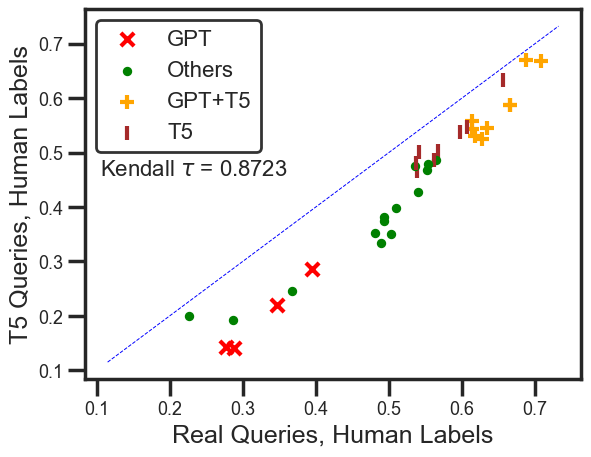

In [23]:
get_plot(runid_to_score_real_nist, runid_to_score_t5_nist, query_types=['Real', 'T5'], label_types=['Human', 'Human'])

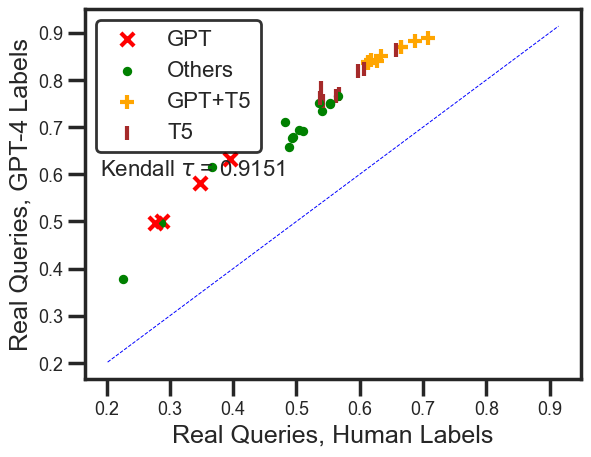

In [24]:
# real vs. track
get_plot(runid_to_score_real_nist, runid_to_score_real_gpt4, query_types=['Real', 'Real'], label_types=['Human', 'GPT-4'])

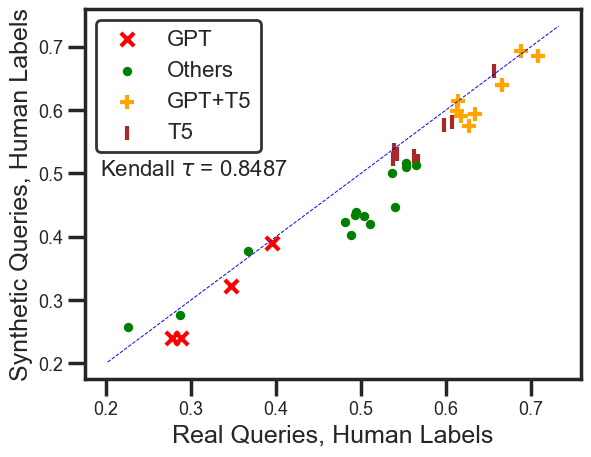

In [25]:
# real vs. track
get_plot(runid_to_score_real_nist, runid_to_score_generated_nist, query_types=['Real', 'Synthetic'], label_types=['Human', 'Human'])